In [21]:
import random
import matplotlib.pyplot as plt #comment this out for autograder
import matplotlib.ticker as ticker #comment this out for autograder
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [28]:
class Bidder1:
    _instance_count = 1  # Class variable to keep track of the number of instances created

    def __init__(self, num_users, num_rounds):
        self.bidder_id = Bidder._instance_count  # Assign a unique ID based on instance count
        Bidder._instance_count += 1  # Increment the instance count
        self.num_users = num_users # number of user objects in the game
        self.num_rounds = num_rounds # the total number of rounds to be played
        self.round_number = 1
        self.approx_train_rounds_per_user = round((self.num_rounds/ self.num_users)/3,0) # take 1/3 of total rounds per for training
        
        
        self.bidder_budget = 0
        self.usr_clickrate_dict = {}
        self.user_aggregate_winrate_dict = {}
        self.user_aggregate_click_dict = {}
        self.final_bid = 0
        self.log = np.array([]) 
        self.personal_bid_pattern = np.array([[self.round_number, None, None, None, self.bidder_budget]])

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    # EV Calculator (Based on Last 10 bets)
    def ev(self, second_price_bid, est_win_rate, est_click_rate):
        """return the expected value of a bid, given the click rate probability of a user X"""
        return (est_click_rate * (1 - second_price_bid) )+ ((1-est_click_rate) * (0 - second_price_bid) ) 

    def bid_price(self, ev, click_rate):
        """return the bid price of a given expected value, relative to the est. click rate"""
        return (click_rate - ev)

    def calculate_ev_lastNbids(self, num_bid_lookback, user_id, user_log, est_win_rate, est_click_rate):
        """calculate the EV w.r.t the last 10 winning bids on a given user"""
        # Filter for user_id (not string object)
        user_log = user_log[user_log[:, 0] == user_id]
        # Find the mean for user ID, based on last N bids
        count_last_N_bids = 0-num_bid_lookback
        mean = user_log[:,2][count_last_N_bids:].mean()
        # Use objective function to return the final EV of last 10 bids mean
        return mean, self.ev(mean, est_win_rate, est_click_rate)

    def submit_ev_bid_price(self, user_id, est_win_rate, est_click_rate, log):
        """Submite a bid price based on the Expected Value (EV) Margins between the estimated click rate ev and the last 5 2nd Price EVs"""
        last10, last10ev =  self.calculate_ev_lastNbids(10, user_id, log, est_win_rate, est_click_rate)
        last3, last3ev =  self.calculate_ev_lastNbids(3, user_id, log, est_win_rate, est_click_rate)
        
        if last10ev < 0:
            self.final_bid = 0.0001
        
        # else:
        #     self.final_bid = (last10+ 0.00001) * 5
        else:
            if last3ev < 0:
                self.final_bid = 0.0001
            else:
                self.final_bid = (last10+ 0.00001) * 5
        
        return self.final_bid
    
    def update_dict(self,user, final_bid, bidder_log):
        """Use the bidder log to update the click rate dictionary"""
        if final_bid == None:
            return
        
        user_log = bidder_log[bidder_log[:, 0] == user]
        if len(user_log) == 0:
            return 0
        
        last_record = user_log[-1]
        _, user_won, _, user_clicked = last_record

        self.usr_clickrate_dict[user]["total_rounds"] += 1
        if user_won:
            self.usr_clickrate_dict[user]["total_wins"] += 1
        if user_clicked:
            self.usr_clickrate_dict[user]["total_clicks"] += 1

        bid_modifier = 1 if user_clicked else 0
        self.bidder_budget += (bid_modifier - final_bid)
    
        if self.usr_clickrate_dict[user]["total_wins"] > 0:
            self.user_aggregate_click_dict[user] = self.usr_clickrate_dict[user]["total_clicks"] / self.usr_clickrate_dict[user]["total_wins"]
            self.user_aggregate_winrate_dict[user] = self.usr_clickrate_dict[user]["total_wins"] / self.usr_clickrate_dict[user]["total_rounds"]
        else:
            self.user_aggregate_click_dict[user] = 0
            self.user_aggregate_winrate_dict[user] = 0
    

    def aggressive_bid(self,user_id, bidder_log):
        """Aggressive Bidding Model. Objective is to bid high to attain the click rate data early on."""
        
        if self.approx_train_rounds_per_user >= 10:
            # Check if the user is not already in the dictionary
            if user_id not in self.usr_clickrate_dict : #and self.bidder_budget >= -12:
                # If the user is not in the dictionary, add a new entry with a nested dictionary
                self.usr_clickrate_dict[user_id] = {
                    "approx_rounds_left": 10,
                    "total_rounds": 0,
                    "total_wins": 0,
                    "total_clicks": 0
                }
                self.user_aggregate_click_dict[user_id] = 0
                self.user_aggregate_winrate_dict[user_id] = 0
                self.final_bid = 1
                return self.final_bid

            elif self.usr_clickrate_dict[user_id]["approx_rounds_left"] > 0 : # and self.bidder_budget >= -12:
                user_log = bidder_log[bidder_log[:, 0] == user_id]
                last_record = user_log[-1,:]
                self.usr_clickrate_dict[user_id]["approx_rounds_left"] -= 1
                # take the most recent bid and final_bid would be double
                self.final_bid = max(last_record[2] * 2,1)
                return self.final_bid
            else:
                return 0

        else:
            # Check if the user is not already in the dictionary
            if user_id not in self.usr_clickrate_dict:
                # If the user is not in the dictionary, add a new entry with a nested dictionary
                self.usr_clickrate_dict[user_id] = {
                    "approx_rounds_left": self.approx_train_rounds_per_user,
                    "total_rounds": 0,
                    "total_wins": 0,
                    "total_clicks": 0
                }

                self.final_bid = 1
                return self.final_bid

            elif self.usr_clickrate_dict[user_id]["approx_rounds_left"] > 0:
                self.usr_clickrate_dict[user_id]["approx_rounds_left"] -= 1
                user_log = bidder_log[bidder_log[:, 0] == user_id]
                
                # take the most recent bid and return double as final_bid
                self.final_bid = user_log[-1:,2] * 2
                return self.final_bid
            else:
                return 0

    def bid(self, user_id):
        """returns a non-negative amount of money, in dollars round to three (3) decimal places."""
        self.user_id = user_id

        if self.user_id not in self.usr_clickrate_dict:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            #self.update_dict(user_id, final_bid, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
            return self.final_bid
        
        elif self.user_id in self.usr_clickrate_dict and self.usr_clickrate_dict[self.user_id]["approx_rounds_left"] > 0 and self.bidder_budget >= -20:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            #self.update_dict(user_id, final_bid, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
            return self.final_bid

        elif self.user_id in self.usr_clickrate_dict and self.usr_clickrate_dict[self.user_id]["approx_rounds_left"] > 7:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            #self.update_dict(user_id, final_bid, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
            return self.final_bid
        else:
            est_win_rate = self.user_aggregate_winrate_dict[self.user_id]
            est_click_rate = self.user_aggregate_click_dict[self.user_id]
            self.final_bid = self.submit_ev_bid_price(self.user_id, est_win_rate, est_click_rate, self.log)
            #final_bid = random.uniform(0,1)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'ev_bid', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
            return self.submit_ev_bid_price(self.user_id, est_win_rate, est_click_rate, self.log)


    def notify(self, auction_winner, price, clicked):
        """send information about what happened in a round back to the Bidder"""
        self.auction_winner = auction_winner #a boolean to represent whether the given bidder won the auction ( True ) or not ( False).

        self.price = price # the amount of the second bid, which the winner pays.

        self.clicked = clicked # If the given bidder won the auction, will contain a boolean value to represent whether the user clicked on the ad
            # if not it will always contain None
        # Append a new row of values to the self.log array
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])
        
        if self.log.size == 0:
            # If self.log is empty, initialize it with new_entry
            self.log = np.array([new_entry])
            self.update_dict(self.user_id, self.final_bid, self.log)
        else:
            # If self.log is not empty, vertically stack new_entry on self.log
            self.log = np.vstack((self.log, new_entry))
            self.update_dict(self.user_id, self.final_bid, self.log)
        #self.log = np.append(self.log, [(self.user_id,self.auction_winner,self.price,self.clicked)],axis=0)

In [29]:
import numpy as np

class Bidder2:
    """Bidder Class for the Auction"""
    _instance_count = 1

    def __init__(self, num_users, num_rounds):
        self.bidder_id = Bidder._instance_count
        Bidder._instance_count += 1
        self.num_users = num_users
        self.num_rounds = num_rounds
        self.round_number = 1
        self.approx_train_rounds_per_user = round((self.num_rounds / self.num_users) / 3, 0)
        self.bidder_budget = 0
        self.usr_clickrate_dict = {}
        self.user_aggregate_click_dict = {}
        self.final_bid = 0
        self.log = np.array([])
        self.personal_bid_pattern = np.array([[self.round_number, None, None, None, self.bidder_budget]])

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    def calculate_expected_value(self, second_price_bid, est_click_rate):
        """Return expected value of a bid given the click rate."""
        return est_click_rate * (1 - second_price_bid) + (1 - est_click_rate) * (0 - second_price_bid)

    def bid_price(self, expected_val, click_rate):
        """Return bid price of a given expected value """
        return click_rate - expected_val

    def calculate_expected_val_last_n_bids(self, num_bid_lookback, user_id, user_log, est_click_rate):
        """Calculate the expected_val with respect to the last N winning bids on a given user."""
        user_log = user_log[user_log[:, 0] == user_id]
        count_last_n_bids = 0 - num_bid_lookback
        mean = user_log[:, 2][count_last_n_bids:].mean()
        return mean, self.calculate_expected_value(mean, est_click_rate)

    def submit_expected_val_bid_price(self, user_id, est_click_rate, log):
        """Submit a bid price based on the expected_val"""
        last10, last10_expected_val = self.calculate_expected_val_last_n_bids(10, user_id, log, est_click_rate)
        _, last3_expected_val = self.calculate_expected_val_last_n_bids(3, user_id, log, est_click_rate)

        if last10_expected_val < 0:
            self.final_bid = 0.0001
        else:
            if last3_expected_val < 0:
                self.final_bid = 0.0001
            else:
                self.final_bid = (last10 + 0.00001) * 5

        return self.final_bid

    def update_dict(self, user, final_bid, bidder_log):
        """Use the bidder log to update the click rate dictionary."""
        if final_bid is None:
            return 0

        user_log = bidder_log[bidder_log[:, 0] == user]
        if len(user_log) == 0:
            return 0

        last_record = user_log[-1]
        _, user_won, _, user_clicked = last_record

        self.usr_clickrate_dict[user]["total_rounds"] += 1
        if user_won:
            self.usr_clickrate_dict[user]["total_wins"] += 1
        if user_clicked:
            self.usr_clickrate_dict[user]["total_clicks"] += 1

        bid_modifier = 1 if user_clicked else 0
        self.bidder_budget += (bid_modifier - final_bid)

        if self.usr_clickrate_dict[user]["total_wins"] > 0:
            self.user_aggregate_click_dict[user] = self.usr_clickrate_dict[user]["total_clicks"] / self.usr_clickrate_dict[user]["total_wins"]
        else:
            self.user_aggregate_click_dict[user] = 0

    def aggressive_bid(self, user_id, bidder_log):
        """Use aggressive bidding method"""
        if self.approx_train_rounds_per_user >= 10:
            if user_id not in self.usr_clickrate_dict:
                self.usr_clickrate_dict[user_id] = {
                    "approx_rounds_left": 10,
                    "total_rounds": 0,
                    "total_wins": 0,
                    "total_clicks": 0
                }
                self.user_aggregate_click_dict[user_id] = 0
                self.final_bid = 1
            elif self.usr_clickrate_dict[user_id]["approx_rounds_left"] > 0:
                user_log = bidder_log[bidder_log[:, 0] == user_id]
                last_record = user_log[-1, :]
                self.usr_clickrate_dict[user_id]["approx_rounds_left"] -= 1
                self.final_bid = max(last_record[2] * 2, 1)
            else:
                self.final_bid = 0
        else:
            if user_id not in self.usr_clickrate_dict:
                self.usr_clickrate_dict[user_id] = {
                    "approx_rounds_left": self.approx_train_rounds_per_user,
                    "total_rounds": 0,
                    "total_wins": 0,
                    "total_clicks": 0
                }
                self.final_bid = 1
            elif self.usr_clickrate_dict[user_id]["approx_rounds_left"] > 0:
                self.usr_clickrate_dict[user_id]["approx_rounds_left"] -= 1
                user_log = bidder_log[bidder_log[:, 0] == user_id]
                self.final_bid = user_log[-1:, 2] * 2
                return self.final_bid
            else:
                self.final_bid = 0
        return self.final_bid

    def bid(self, user_id):
        """Return Bid to auction."""
        self.user_id = user_id

        if self.user_id not in self.usr_clickrate_dict:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
        elif self.user_id in self.usr_clickrate_dict and self.usr_clickrate_dict[self.user_id]["approx_rounds_left"] > 0 and self.bidder_budget >= -20:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
        elif self.user_id in self.usr_clickrate_dict and self.usr_clickrate_dict[self.user_id]["approx_rounds_left"] > 7:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
        else:
            est_click_rate = self.user_aggregate_click_dict[self.user_id]
            self.final_bid = self.submit_expected_val_bid_price(self.user_id, est_click_rate, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'expected_val_bid', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
        
        return self.final_bid

    def notify(self, auction_winner, price, clicked):
        """Append auction details to internal log."""
        self.auction_winner = auction_winner
        self.price = price
        self.clicked = clicked
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])

        if self.log.size == 0:
            self.log = np.array([new_entry])
            self.update_dict(self.user_id, self.final_bid, self.log)
        else:
            self.log = np.vstack((self.log, new_entry))
            self.update_dict(self.user_id, self.final_bid, self.log)


In [30]:
class Bidder3:
    _instance_count = 1  # Class variable to keep track of the number of instances created

    def __init__(self, num_users, num_rounds):
        self.num_users = num_users # number of user objects in the game
        self.num_rounds = num_rounds # the total number of rounds to be played
        self.bidder_id = Bidder._instance_count  # Assign a unique ID based on instance count
        Bidder._instance_count += 1  # Increment the instance count
        # The bidder might want to use this info to help plan its strategy.
        # create a log of bidding pattern.
        self.log = np.array([]) 

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    def bid(self, user_id):
        """returns a non-negative amount of money, in dollars round to three (3) decimal places."""
        self.user_id = user_id
        final_bid = random.uniform(-.01,0.25)
        #final_bid = 1
        return final_bid

    def notify(self, auction_winner, price, clicked):
        """send information about what happened in a round back to the Bidder"""
        self.auction_winner = auction_winner #a boolean to represent whether the given bidder won the auction ( True ) or not ( False).

        self.price = price # the amount of the second bid, which the winner pays.

        self.clicked = clicked # If the given bidder won the auction, will contain a boolean value to represent whether the user clicked on the ad
            # if not it will always contain None
        # Append a new row of values to the self.log array
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])
        
        if self.log.size == 0:
            # If self.log is empty, initialize it with new_entry
            self.log = new_entry
        else:
            # If self.log is not empty, vertically stack new_entry on self.log
            self.log = np.vstack((self.log, new_entry))
        #self.log = np.append(self.log, [(self.user_id,self.auction_winner,self.price,self.clicked)],axis=0)

In [31]:
class Bidder4:
    _instance_count = 1  # Class variable to keep track of the number of instances created

    def __init__(self, num_users, num_rounds):
        self.num_users = num_users # number of user objects in the game
        self.num_rounds = num_rounds # the total number of rounds to be played
        self.bidder_id = Bidder._instance_count  # Assign a unique ID based on instance count
        Bidder._instance_count += 1  # Increment the instance count
        # The bidder might want to use this info to help plan its strategy.
        # create a log of bidding pattern.
        self.log = np.array([]) 

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    def bid(self, user_id):
        """returns a non-negative amount of money, in dollars round to three (3) decimal places."""
        self.user_id = user_id
        final_bid = random.gauss(0.5,1)
        #final_bid = 1
        return final_bid

    def notify(self, auction_winner, price, clicked):
        """send information about what happened in a round back to the Bidder"""
        self.auction_winner = auction_winner #a boolean to represent whether the given bidder won the auction ( True ) or not ( False).

        self.price = price # the amount of the second bid, which the winner pays.

        self.clicked = clicked # If the given bidder won the auction, will contain a boolean value to represent whether the user clicked on the ad
            # if not it will always contain None
        # Append a new row of values to the self.log array
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])
        
        if self.log.size == 0:
            # If self.log is empty, initialize it with new_entry
            self.log = new_entry
        else:
            # If self.log is not empty, vertically stack new_entry on self.log
            self.log = np.vstack((self.log, new_entry))
        #self.log = np.append(self.log, [(self.user_id,self.auction_winner,self.price,self.clicked)],axis=0)

In [32]:
class Bidder5:
    _instance_count = 1  # Class variable to keep track of the number of instances created

    def __init__(self, num_users, num_rounds):
        self.num_users = num_users # number of user objects in the game
        self.num_rounds = num_rounds # the total number of rounds to be played
        self.bidder_id = Bidder._instance_count  # Assign a unique ID based on instance count
        Bidder._instance_count += 1  # Increment the instance count
        # The bidder might want to use this info to help plan its strategy.
        # create a log of bidding pattern.
        self.log = np.array([]) 

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    def bid(self, user_id):
        """returns a non-negative amount of money, in dollars round to three (3) decimal places."""
        self.user_id = user_id
        final_bid = random.gauss(0.45, 1)
        #final_bid = 1
        return final_bid

    def notify(self, auction_winner, price, clicked):
        """send information about what happened in a round back to the Bidder"""
        self.auction_winner = auction_winner #a boolean to represent whether the given bidder won the auction ( True ) or not ( False).

        self.price = price # the amount of the second bid, which the winner pays.

        self.clicked = clicked # If the given bidder won the auction, will contain a boolean value to represent whether the user clicked on the ad
            # if not it will always contain None
        # Append a new row of values to the self.log array
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])
        
        if self.log.size == 0:
            # If self.log is empty, initialize it with new_entry
            self.log = new_entry
        else:
            # If self.log is not empty, vertically stack new_entry on self.log
            self.log = np.vstack((self.log, new_entry))
        #self.log = np.append(self.log, [(self.user_id,self.auction_winner,self.price,self.clicked)],axis=0)

Balances after 1000 rounds:
{b1: 0, b2: -102.95543244447383, b3: -134.6347479613241, b4: 56.647837784844306, b5: -5.84743152496642, b6: -0.16974681047493645}

Balances history after 10 rounds:
Bidder: b1, Round: 1, Bid: 0, Users: u2, User_Clicked: False, Balance: 0
Bidder: b2, Round: 1, Bid: 1, Users: u2, User_Clicked: False, Balance: 0
Bidder: b3, Round: 1, Bid: 1, Users: u2, User_Clicked: False, Balance: 0
Bidder: b4, Round: 1, Bid: 0.243, Users: u2, User_Clicked: False, Balance: 0
Bidder: b5, Round: 1, Bid: 2.616, Users: u2, User_Clicked: False, Balance: -1
Bidder: b6, Round: 1, Bid: 0.063, Users: u2, User_Clicked: False, Balance: 0
Bidder: b1, Round: 2, Bid: 0, Users: u3, User_Clicked: False, Balance: 0
Bidder: b2, Round: 2, Bid: 1, Users: u3, User_Clicked: False, Balance: 0
Bidder: b3, Round: 2, Bid: 1, Users: u3, User_Clicked: False, Balance: -1
Bidder: b4, Round: 2, Bid: 0.174, Users: u3, User_Clicked: False, Balance: 0
Bidder: b5, Round: 2, Bid: 0, Users: u3, User_Clicked: Fals

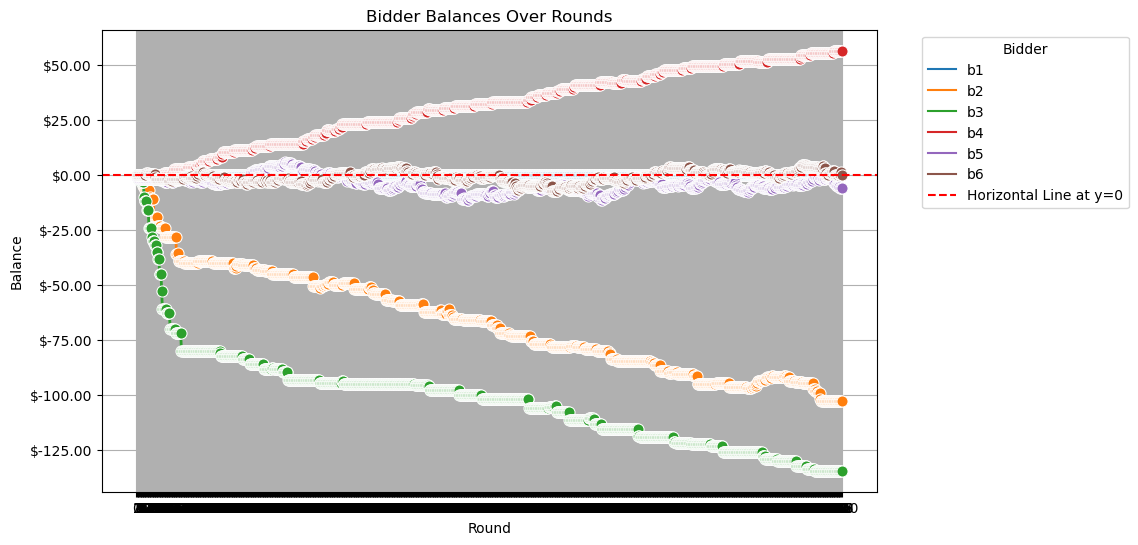

In [34]:
# Design the following classes

import random
import numpy as np

class User:
    """User Class for the Auction"""
    _instance_count = 0
    def __init__(self):
        self.__probability = random.uniform(0,1)
        self.user_id = User._instance_count
        User._instance_count += 1

    def __repr__(self):
        return f"u{self.user_id}"

    def __str__(self):
        return f"u{self.user_id}"
    
    def show_ad(self):
        """This method should return True to represent the user clicking on and ad and
            otherwise."""
        return True if np.random.rand() <= self.__probability else False


class Bidder:
    _instance_count = 1  # Class variable to keep track of the number of instances created

    def __init__(self, num_users, num_rounds):
        self.num_users = num_users # number of user objects in the game
        self.num_rounds = num_rounds # the total number of rounds to be played
        self.bidder_id = Bidder._instance_count  # Assign a unique ID based on instance count
        Bidder._instance_count += 1  # Increment the instance count
        # The bidder might want to use this info to help plan its strategy.
        # create a log of bidding pattern.
        self.log = np.array([]) 

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    def bid(self, user_id):
        """returns a non-negative amount of money, in dollars round to three (3) decimal places."""
        self.user_id = user_id
        #final_bid = random.uniform(0.5,1.5)
        final_bid = 0
        return final_bid

    def notify(self, auction_winner, price, clicked):
        """send information about what happened in a round back to the Bidder"""
        self.auction_winner = auction_winner #a boolean to represent whether the given bidder won the auction ( True ) or not ( False).

        self.price = price # the amount of the second bid, which the winner pays.

        self.clicked = clicked # If the given bidder won the auction, will contain a boolean value to represent whether the user clicked on the ad
            # if not it will always contain None
        # Append a new row of values to the self.log array
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])
        
        if self.log.size == 0:
            # If self.log is empty, initialize it with new_entry
            self.log = new_entry
        else:
            # If self.log is not empty, vertically stack new_entry on self.log
            self.log = np.vstack((self.log, new_entry))
        #self.log = np.append(self.log, [(self.user_id,self.auction_winner,self.price,self.clicked)],axis=0)

class Auction:
    
    def __init__(self, users, bidders):
        self.users = users
        self.bidders = bidders
        self.balances = {bidder: 0 for bidder in self.bidders}
        self.balances_history = []
        self.round_count = 1

    def __repr__(self):
        return f"Auction(users={self.users}, bidders={self.bidders})"

    def __str__(self):
        return f"Auction with {len(self.users)} users and {len(self.bidders)} bidders"

    def execute_round(self):
        """Execute all steps within a single round of the game."""
        user_id = random.choice(self.users)
        bids = {}

        for bidder in self.bidders:
            final_bid = bidder.bid(user_id)
            bids[bidder] = max(0, final_bid)

        highest_bid = max((bid for bid in bids.values() if bid is not None), default=None)
        tie_bidders = [bidder for bidder, bid in bids.items() if bid == highest_bid]

        if len(tie_bidders) >= 2:
            winner = random.choice(tie_bidders)
            tie_bidders.remove(winner)
            second_highest_bid = bids[random.choice(tie_bidders)]
        else:
            winner = tie_bidders[0]
            second_highest_bid = float('-inf')

        for bidder, bid in bids.items():
            if bid is not None and bid > second_highest_bid and bidder != winner:
                second_highest_bid = bid

        clicked = user_id.show_ad()

        for bidder in self.bidders:
            if bidder == winner:
                bidder.notify(auction_winner=True, price=second_highest_bid, clicked=clicked)
                if clicked:
                    self.balances[winner] += (1 - second_highest_bid)
                else:
                    self.balances[winner] -= second_highest_bid
            else:
                bidder.notify(auction_winner=False, price=second_highest_bid, clicked=None)
                self.balances[bidder] -= 0

        for bidder in self.bidders:
            self.balances_history.append((bidder, self.round_count, bids[bidder], user_id, clicked, self.balances[bidder]))
        self.round_count += 1
        
    def plot_history(self):
        """Creates a visual representation of how the auction has proceeded using Seaborn."""
        plt.figure(figsize=(10, 6))

        # Extract data for Seaborn plot
        bidder_ids = []
        rounds = []
        bids = []
        users = []
        clicked_values = []
        balances = []
        for bidder, round_num, bid, chosen_user_id, clicked, balance in self.balances_history:
            bidder_ids.append(str(bidder))
            rounds.append(round_num)
            bids.append(bid)
            users.append(chosen_user_id)
            clicked_values.append(clicked)
            balances.append(balance)

        # Create a Seaborn line plot
        data = {'Bidder': bidder_ids, 'Round': rounds, 'Bid': bids, 'Chosen User': users, 'Clicked': clicked_values, 'Balance': balances}
        df = pd.DataFrame(data)
        sns.lineplot(data=df, x='Round', y='Balance', hue='Bidder', marker='o', markersize=8, linewidth=2)

        # Draw horizontal line at y=0
        plt.axhline(y=0, color='red', linestyle='--', label='Horizontal Line at y=0')

        plt.xlabel('Round')
        plt.ylabel('Balance')
        plt.title('Bidder Balances Over Rounds')
        plt.xticks(range(self.round_count))
        plt.legend(title='Bidder', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)

        # Format y-axis as currency (US dollars)
        currency_format = ticker.StrMethodFormatter('${x:,.2f}')
        plt.gca().yaxis.set_major_formatter(currency_format)
        plt.show()


if __name__ == "__main__":
    user_count = 9
    round_count = 1000
    b1, b2, b3, b4, b5, b10= Bidder(user_count,round_count), Bidder1(user_count,round_count), Bidder2(user_count,round_count), Bidder3(user_count,round_count), Bidder4(user_count,round_count), Bidder5(user_count,round_count)
    u0, u1, u2, u3, u4, u5, u6, u7, u8 = User(), User(), User(),User(), User(), User(),User(), User(), User()
    auction = Auction([u0, u1, u2, u3, u4, u5, u6, u7, u8],[b1, b2, b3, b4, b5, b10])
    
    # Run multiple rounds (for example, 10 rounds)
    for _ in range(round_count):
        auction.execute_round()

    # Print balances and balances_history after 10 rounds
    print(f"Balances after {round_count} rounds:")
    print(auction.balances)
    
    print("\nBalances history after 10 rounds:")
    for bidder, round_num, bid, users, clicked, balance in auction.balances_history:
        print(f"Bidder: {bidder}, Round: {round_num}, Bid: {round(bid,3)}, Users: {users}, User_Clicked: {clicked}, Balance: {round(balance,3)}")

    # Plot the auction history after 10 rounds using Seaborn
    auction.plot_history()

In [35]:
print(f"u0 : {u0._User__probability}")
print(f"u1 : {u1._User__probability}")
print(f"u2 : {u2._User__probability}")
print(f"u3 : {u3._User__probability}")
print(f"u4 : {u4._User__probability}")
print(f"u5 : {u5._User__probability}")
print(f"u6 : {u6._User__probability}")
print(f"u7 : {u7._User__probability}")
print(f"u8 : {u8._User__probability}")

u0 : 0.008512601889254512
u1 : 0.5708207830944568
u2 : 0.10497640085549964
u3 : 0.4295098921891226
u4 : 0.8534433515617553
u5 : 0.5695769023193563
u6 : 0.056743448409778185
u7 : 0.4647213517225973
u8 : 0.9008976265334863


In [5]:
for bidder, round_num, bid, users, clicked, balance in auction.balances_history[2880:]:
        if users == u3:
            print(f"Bidder: {bidder}, Round: {round_num}, Bid: {round(bid,3)}, Users: {users}, User_Clicked: {clicked}, Balance: {round(balance,3)}")


NameError: name 'auction' is not defined

In [335]:
# Import necessary modules
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from auction_naidoo import User, Auction  # Import User and Auction classes from external file
from bidder_naidoo import Bidder         # Import Bidder class from external file

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [1]:


# Main Functionality
if __name__ == "__main__":
    # Parameters
    user_count = 9  # Number of users
    round_count = 1000  # Number of auction rounds

    # Create users
    users = [User() for _ in range(user_count)]

    # Create bidders
    bidders = [Bidder(user_count, round_count) for _ in range(5)]

    # Initialize auction
    auction = Auction(users, bidders)

    # Run the auction for the specified number of rounds
    for _ in range(round_count):
        auction.execute_round()

    # Print final balances after all rounds
    print(f"Final Balances after {round_count} rounds:")
    for bidder, balance in auction.balances.items():
        print(f"Bidder {bidder}: ${balance:.2f}")

    # Print a portion of the balance history
    print("\nSample Balances History:")
    for record in auction.balances_history[:10]:  # Show the first 10 records as a sample
        bidder, round_num, bid, user, clicked, balance = record
        print(f"Bidder: {bidder}, Round: {round_num}, Bid: {round(bid, 3)}, User: {user}, "
              f"Clicked: {clicked}, Balance: {round(balance, 3)}")

    # Plot the auction history
    def plot_history(auction):
        """Visualizes the auction's progress using a line plot."""
        plt.figure(figsize=(12, 6))

        # Extract auction data for plotting
        data = {
            'Bidder': [str(record[0]) for record in auction.balances_history],
            'Round': [record[1] for record in auction.balances_history],
            'Balance': [record[5] for record in auction.balances_history]
        }
        df = pd.DataFrame(data)

        # Plot balance over rounds for each bidder
        sns.lineplot(data=df, x='Round', y='Balance', hue='Bidder', marker='o', linewidth=1.5)

        # Add horizontal reference line at y=0
        plt.axhline(0, color='red', linestyle='--', label='Break-even Line')

        # Set labels, title, and legend
        plt.xlabel('Round')
        plt.ylabel('Balance')
        plt.title('Bidder Balances Over Auction Rounds')
        plt.legend(title='Bidder', loc='upper left', bbox_to_anchor=(1.05, 1))
        plt.grid(True)

        # Format y-axis as currency
        formatter = ticker.StrMethodFormatter('${x:,.2f}')
        plt.gca().yaxis.set_major_formatter(formatter)

        # Show the plot
        plt.tight_layout()
        plt.show()

    # Call the plotting function
    plot_history(auction)

NameError: name 'User' is not defined

Balances after 1000 rounds:
{b1: 0, b2: 0, b3: 6.794631725583852, b4: 0, b5: 0, b6: 376.83429689203854}

Balances history after 10 rounds:
Bidder: b1, Round: 1, Bid: 0, Users: u4, User_Clicked: True, Balance: 0
Bidder: b2, Round: 1, Bid: 0, Users: u4, User_Clicked: True, Balance: 0
Bidder: b3, Round: 1, Bid: 0.036, Users: u4, User_Clicked: True, Balance: 0
Bidder: b4, Round: 1, Bid: 0, Users: u4, User_Clicked: True, Balance: 0
Bidder: b5, Round: 1, Bid: 0, Users: u4, User_Clicked: True, Balance: 0
Bidder: b6, Round: 1, Bid: 1, Users: u4, User_Clicked: True, Balance: 0.964
Bidder: b1, Round: 2, Bid: 0, Users: u5, User_Clicked: False, Balance: 0
Bidder: b2, Round: 2, Bid: 0, Users: u5, User_Clicked: False, Balance: 0
Bidder: b3, Round: 2, Bid: 0.059, Users: u5, User_Clicked: False, Balance: 0
Bidder: b4, Round: 2, Bid: 0, Users: u5, User_Clicked: False, Balance: 0
Bidder: b5, Round: 2, Bid: 0, Users: u5, User_Clicked: False, Balance: 0
Bidder: b6, Round: 2, Bid: 1, Users: u5, User_Clicke

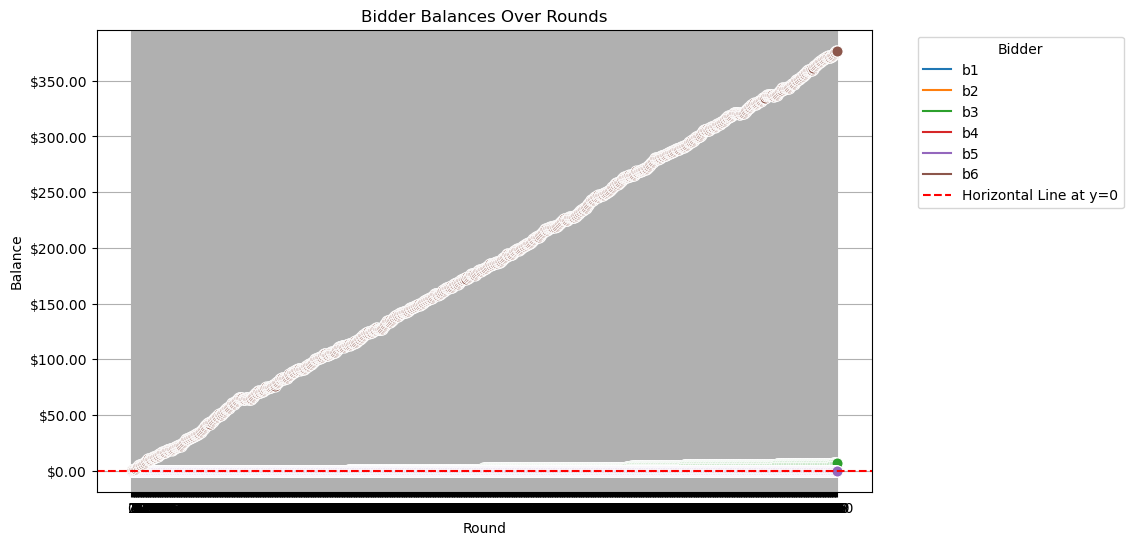

In [336]:


# Main Functionality
if __name__ == "__main__":
    # Parameters
    user_count = 9  # Number of users
    round_count = 1000  # Number of auction rounds

    # Create users
    users = [User() for _ in range(user_count)]

    # Create bidders
    bidders = [Bidder(user_count, round_count) for _ in range(5)]

    # Initialize auction
    auction = Auction(users, bidders)

    # Run the auction for the specified number of rounds
    for _ in range(round_count):
        auction.execute_round()

    # Print final balances after all rounds
    print(f"Final Balances after {round_count} rounds:")
    for bidder, balance in auction.balances.items():
        print(f"Bidder {bidder}: ${balance:.2f}")

    # Print a portion of the balance history
    print("\nSample Balances History:")
    for record in auction.balances_history[:10]:  # Show the first 10 records as a sample
        bidder, round_num, bid, user, clicked, balance = record
        print(f"Bidder: {bidder}, Round: {round_num}, Bid: {round(bid, 3)}, User: {user}, "
              f"Clicked: {clicked}, Balance: {round(balance, 3)}")

    # Plot the auction history
    def plot_history(auction):
        """Visualizes the auction's progress using a line plot."""
        plt.figure(figsize=(12, 6))

        # Extract auction data for plotting
        data = {
            'Bidder': [str(record[0]) for record in auction.balances_history],
            'Round': [record[1] for record in auction.balances_history],
            'Balance': [record[5] for record in auction.balances_history]
        }
        df = pd.DataFrame(data)

        # Plot balance over rounds for each bidder
        sns.lineplot(data=df, x='Round', y='Balance', hue='Bidder', marker='o', linewidth=1.5)

        # Add horizontal reference line at y=0
        plt.axhline(0, color='red', linestyle='--', label='Break-even Line')

        # Set labels, title, and legend
        plt.xlabel('Round')
        plt.ylabel('Balance')
        plt.title('Bidder Balances Over Auction Rounds')
        plt.legend(title='Bidder', loc='upper left', bbox_to_anchor=(1.05, 1))
        plt.grid(True)

        # Format y-axis as currency
        formatter = ticker.StrMethodFormatter('${x:,.2f}')
        plt.gca().yaxis.set_major_formatter(formatter)

        # Show the plot
        plt.tight_layout()
        plt.show()

    # Call the plotting function
    plot_history(auction)

In [318]:
print(f"u0 : {u0._User__probability}")
print(f"u1 : {u1._User__probability}")
print(f"u2 : {u2._User__probability}")
print(f"u3 : {u3._User__probability}")
print(f"u4 : {u4._User__probability}")
print(f"u5 : {u5._User__probability}")
print(f"u6 : {u6._User__probability}")
print(f"u7 : {u7._User__probability}")
print(f"u8 : {u8._User__probability}")

u0 : 0.6532520889682646
u1 : 0.08918967492045793
u2 : 0.8226497987067103
u3 : 0.3850174676790572
u4 : 0.5226407898823144
u5 : 0.0955016888218414
u6 : 0.6961430699503525
u7 : 0.27265077976081986
u8 : 0.6880379338260137


In [304]:
for bidder, round_num, bid, users, clicked, balance in auction.balances_history[2880:]:
        if users == u3:
            print(f"Bidder: {bidder}, Round: {round_num}, Bid: {round(bid,3)}, Users: {users}, User_Clicked: {clicked}, Balance: {round(balance,3)}")


Bidder: b1, Round: 482, Bid: 0, Users: u3, User_Clicked: True, Balance: 0
Bidder: b2, Round: 482, Bid: 0.603, Users: u3, User_Clicked: True, Balance: -124.836
Bidder: b3, Round: 482, Bid: 0.129, Users: u3, User_Clicked: True, Balance: -45.97
Bidder: b4, Round: 482, Bid: 0, Users: u3, User_Clicked: True, Balance: -126.878
Bidder: b5, Round: 482, Bid: 0, Users: u3, User_Clicked: True, Balance: 0
Bidder: b6, Round: 482, Bid: 3.033, Users: u3, User_Clicked: True, Balance: -54.328
Bidder: b1, Round: 487, Bid: 0, Users: u3, User_Clicked: True, Balance: 0
Bidder: b2, Round: 487, Bid: 0.185, Users: u3, User_Clicked: True, Balance: -126.298
Bidder: b3, Round: 487, Bid: 0.051, Users: u3, User_Clicked: True, Balance: -46.293
Bidder: b4, Round: 487, Bid: 1.582, Users: u3, User_Clicked: True, Balance: -128.281
Bidder: b5, Round: 487, Bid: 0, Users: u3, User_Clicked: True, Balance: 0
Bidder: b6, Round: 487, Bid: 3.32, Users: u3, User_Clicked: True, Balance: -55.774
Bidder: b1, Round: 490, Bid: 0, Us

In [95]:
np.mean([0.523,0.216,0.51,0.557])

0.4515

In [97]:
est_click_rate = 0.6237623762376238
second_price_bid = 0.4515
(est_click_rate * (1 - second_price_bid) )+ ((1-est_click_rate) * (0 - second_price_bid) ) 

0.17226237623762372

In [238]:
print(f"win rate : {b10.user_aggregate_winrate_dict}")
print(f"click rate : {b10.user_aggregate_click_dict}")
b10.usr_clickrate_dict

win rate : {u6: 0.02631578947368421, u8: 0.4368932038834951, u2: 0.00980392156862745, u0: 0.504424778761062, u5: 0.9519230769230769, u3: 0.01680672268907563, u4: 0.4214876033057851, u7: 0.009009009009009009, u1: 0}
click rate : {u6: 0.0, u8: 0.4222222222222222, u2: 0.0, u0: 0.43859649122807015, u5: 0.9797979797979798, u3: 0.0, u4: 0.5098039215686274, u7: 0.0, u1: 0}


{u6: {'approx_rounds_left': 7,
  'total_rounds': 114,
  'total_wins': 3,
  'total_clicks': 0},
 u8: {'approx_rounds_left': 7,
  'total_rounds': 103,
  'total_wins': 45,
  'total_clicks': 19},
 u2: {'approx_rounds_left': 10,
  'total_rounds': 102,
  'total_wins': 1,
  'total_clicks': 0},
 u0: {'approx_rounds_left': 8,
  'total_rounds': 113,
  'total_wins': 57,
  'total_clicks': 25},
 u5: {'approx_rounds_left': 7,
  'total_rounds': 104,
  'total_wins': 99,
  'total_clicks': 97},
 u3: {'approx_rounds_left': 9,
  'total_rounds': 119,
  'total_wins': 2,
  'total_clicks': 0},
 u4: {'approx_rounds_left': 10,
  'total_rounds': 121,
  'total_wins': 51,
  'total_clicks': 26},
 u7: {'approx_rounds_left': 10,
  'total_rounds': 111,
  'total_wins': 1,
  'total_clicks': 0},
 u1: {'approx_rounds_left': 10,
  'total_rounds': 113,
  'total_wins': 0,
  'total_clicks': 0}}

In [253]:
print(f"u0 : {u0._User__probability}")
print(f"u1 : {u1._User__probability}")
print(f"u2 : {u2._User__probability}")
print(f"u3 : {u3._User__probability}")
print(f"u4 : {u4._User__probability}")
print(f"u5 : {u5._User__probability}")
print(f"u6 : {u6._User__probability}")
print(f"u7 : {u7._User__probability}")
print(f"u8 : {u8._User__probability}")

u0 : 0.9925756902548414
u1 : 0.7781371308528549
u2 : 0.13701340804534
u3 : 0.07582784955525079
u4 : 0.020813432871226945
u5 : 0.04727125774643215
u6 : 0.12993800575278824
u7 : 0.05563487606403428
u8 : 0.7037468199030403


In [254]:
print(f"click rate : {b10.user_aggregate_click_dict}")

click rate : {u0: 0.981651376146789, u5: 0.0, u3: 0.0, u2: 0.0, u6: 0.0, u1: 0.7674418604651163, u7: 0.0, u8: 0.6933333333333334, u4: 0.0}


In [207]:
b10.log[-35:]

array([[u2, True, 0.6719964663551768, True],
       [u1, True, 0.350002391313382, False],
       [u1, True, 0.059517466569954186, True],
       [u1, True, 1.1559665203571408, True],
       [u2, True, 0.7219609167544784, False],
       [u0, True, 1.9618044424877312, False],
       [u0, False, 0.09383932468716001, None],
       [u0, False, 0.05225645998120384, None],
       [u1, True, 0.29100334055136046, True],
       [u2, True, 1.4236571027078329, True],
       [u1, True, 0.7332810005212809, True],
       [u2, True, 0.7420288334788553, True],
       [u1, True, 0.7914550175902597, True],
       [u0, False, 0.19985944183299187, None],
       [u0, False, 0.023504449283511003, None],
       [u2, True, 0.5502447484120058, True],
       [u0, False, 0.014276786576761848, None],
       [u1, True, 0.5934122354763631, True],
       [u0, True, 1.3842971689023749, False],
       [u2, True, 0.6511029050334585, True],
       [u1, True, 0.2480242884281899, True],
       [u0, False, 0.490705248227075,

NameError: name 'b4' is not defined

In [88]:
count = 0
u0_count = 0
click = 0
for bidder, round_num, bid, users, clicked, balance in auction.balances_history:
        if users == u0:
            if clicked == True:
                click += 1
            u0_count += 1
        count += 1
            

In [89]:
count

5000

In [90]:
u0_count

2465

In [91]:
click

300

In [28]:
click / u0_count

0.16326530612244897

In [182]:
print(f"win rate : {b10.user_aggregate_winrate_dict}")
print(f"click rate : {b10.user_aggregate_click_dict}")
b10.usr_clickrate_dict

win rate : {u1: 0.005555555555555556, u0: 0.024539877300613498, u2: 0.6050955414012739}
click rate : {u1: 0.0, u0: 0.125, u2: 0.6578947368421053}


{u1: {'approx_rounds_left': 9,
  'total_rounds': 360,
  'total_wins': 2,
  'total_clicks': 0},
 u0: {'approx_rounds_left': 4,
  'total_rounds': 326,
  'total_wins': 8,
  'total_clicks': 1},
 u2: {'approx_rounds_left': 10,
  'total_rounds': 314,
  'total_wins': 190,
  'total_clicks': 125}}

In [183]:
print(f"u0 : {u0._User__probability}")
print(f"u1 : {u1._User__probability}")
print(f"u2 : {u2._User__probability}")

u0 : 0.11009589759003846
u1 : 0.03845841291489771
u2 : 0.6999080026348554


In [208]:
b10.log[(b10.log[:,0]==u6)]

array([], shape=(0, 4), dtype=object)

In [210]:
usr = u2

b10.submit_ev_bid_price(usr, b10.user_aggregate_winrate_dict[usr], b10.user_aggregate_click_dict[usr], b10.log)

4.0261897313567285

In [186]:
last5, last5ev =  b10.calculate_ev_lastNbids(10,usr,b10.log, b10.user_aggregate_winrate_dict[usr], b10.user_aggregate_click_dict[usr])

In [188]:
last5

0.6924322168460149

In [189]:
last5ev

-0.03453748000390955

In [190]:
b10.final_bid

0.0001

In [191]:
# If balance is negative, then use (0 - balance) to determine needed ev. Max(ev)
# If balance is positive, then use ml_bid price to determine the next bid price, and bid 20% higher.

# depending on the win rate, increase the 20% higher

In [212]:
#ubids = b10.personal_bid_pattern[b10.personal_bid_pattern[:,1]==usr]
ubids = b10.personal_bid_pattern
ubids[-20:,:]

array([[981, u2, 'ev_bid', 4.1137834520486285, -1673.0755108022438],
       [982, u0, 'ev_bid', 0.0001, -1676.1892942542925],
       [983, u1, 'ev_bid', 3.4527069144085267, -1676.1893942542924],
       [984, u0, 'ev_bid', 1.798568638171473, -1678.642101168701],
       [985, u2, 'ev_bid', 4.064936923606953, -1680.4406698068724],
       [986, u1, 'ev_bid', 3.495400687280646, -1683.5056067304793],
       [987, u0, 'ev_bid', 0.0001, -1686.0010074177599],
       [988, u0, 'ev_bid', 0.0001, -1686.0011074177598],
       [989, u2, 'ev_bid', 4.169101571466631, -1686.0012074177598],
       [990, u0, 'ev_bid', 0.0001, -1689.1703089892264],
       [991, u2, 'ev_bid', 4.110105630842501, -1689.1704089892264],
       [992, u0, 'ev_bid', 0.0001, -1692.280514620069],
       [993, u0, 'ev_bid', 1.3791592631569773, -1692.280614620069],
       [994, u2, 'ev_bid', 3.530767586098196, -1693.6597738832259],
       [995, u2, 'ev_bid', 3.6994801065962406, -1696.190541469324],
       [996, u2, 'ev_bid', 3.573430

# Create Dynamic Bidder

In [299]:
class Bidder1:
    _instance_count = 1  # Class variable to keep track of the number of instances created

    def __init__(self, num_users, num_rounds):
        self.bidder_id = Bidder._instance_count  # Assign a unique ID based on instance count
        Bidder._instance_count += 1  # Increment the instance count
        self.num_users = num_users # number of user objects in the game
        self.num_rounds = num_rounds # the total number of rounds to be played
        self.round_number = 1
        self.approx_train_rounds_per_user = round((self.num_rounds/ self.num_users)/3,0) # take 1/3 of total rounds per for training
        
        
        self.bidder_budget = 0
        self.usr_clickrate_dict = {}
        self.user_aggregate_winrate_dict = {}
        self.user_aggregate_click_dict = {}
        self.final_bid = 0
        self.log = np.array([]) 
        self.personal_bid_pattern = np.array([[self.round_number, None, None, None, self.bidder_budget]])

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    # EV Calculator (Based on Last 10 bets)
    def ev(self, second_price_bid, est_win_rate, est_click_rate):
        """return the expected value of a bid, given the click rate probability of a user X"""
        return (est_click_rate * (1 - second_price_bid) )+ ((1-est_click_rate) * (0 - second_price_bid) ) 

    def bid_price(self, ev, click_rate):
        """return the bid price of a given expected value, relative to the est. click rate"""
        return (click_rate - ev)

    def calculate_ev_lastNbids(self, num_bid_lookback, user_id, user_log, est_win_rate, est_click_rate):
        """calculate the EV w.r.t the last 10 winning bids on a given user"""
        # Filter for user_id (not string object)
        user_log = user_log[user_log[:, 0] == user_id]
        # Find the mean for user ID, based on last N bids
        count_last_N_bids = 0-num_bid_lookback
        mean = user_log[:,2][count_last_N_bids:].mean()
        # Use objective function to return the final EV of last 10 bids mean
        return mean, self.ev(mean, est_win_rate, est_click_rate)

    def submit_ev_bid_price(self, user_id, est_win_rate, est_click_rate, log):
        """Submite a bid price based on the Expected Value (EV) Margins between the estimated click rate ev and the last 5 2nd Price EVs"""
        last10, last10ev =  self.calculate_ev_lastNbids(10, user_id, log, est_win_rate, est_click_rate)
        last3, last3ev =  self.calculate_ev_lastNbids(3, user_id, log, est_win_rate, est_click_rate)
        
        if last10ev < 0:
            self.final_bid = 0.0001
        
        # else:
        #     self.final_bid = (last10+ 0.00001) * 5
        else:
            if last3ev < 0:
                self.final_bid = 0.0001
            else:
                self.final_bid = (last10+ 0.00001) * 5
        
        return self.final_bid
    
    def update_dict(self,user, final_bid, bidder_log):
        """Use the bidder log to update the click rate dictionary"""
        if final_bid == None:
            return
        
        user_log = bidder_log[bidder_log[:, 0] == user]
        if len(user_log) == 0:
            return 0
        
        last_record = user_log[-1]
        _, user_won, _, user_clicked = last_record

        self.usr_clickrate_dict[user]["total_rounds"] += 1
        if user_won:
            self.usr_clickrate_dict[user]["total_wins"] += 1
        if user_clicked:
            self.usr_clickrate_dict[user]["total_clicks"] += 1

        bid_modifier = 1 if user_clicked else 0
        self.bidder_budget += (bid_modifier - final_bid)
    
        if self.usr_clickrate_dict[user]["total_wins"] > 0:
            self.user_aggregate_click_dict[user] = self.usr_clickrate_dict[user]["total_clicks"] / self.usr_clickrate_dict[user]["total_wins"]
            self.user_aggregate_winrate_dict[user] = self.usr_clickrate_dict[user]["total_wins"] / self.usr_clickrate_dict[user]["total_rounds"]
        else:
            self.user_aggregate_click_dict[user] = 0
            self.user_aggregate_winrate_dict[user] = 0
    

    def aggressive_bid(self,user_id, bidder_log):
        """Aggressive Bidding Model. Objective is to bid high to attain the click rate data early on."""
        
        if self.approx_train_rounds_per_user >= 10:
            # Check if the user is not already in the dictionary
            if user_id not in self.usr_clickrate_dict : #and self.bidder_budget >= -12:
                # If the user is not in the dictionary, add a new entry with a nested dictionary
                self.usr_clickrate_dict[user_id] = {
                    "approx_rounds_left": 10,
                    "total_rounds": 0,
                    "total_wins": 0,
                    "total_clicks": 0
                }
                self.user_aggregate_click_dict[user_id] = 0
                self.user_aggregate_winrate_dict[user_id] = 0
                self.final_bid = 1
                return self.final_bid

            elif self.usr_clickrate_dict[user_id]["approx_rounds_left"] > 0 : # and self.bidder_budget >= -12:
                user_log = bidder_log[bidder_log[:, 0] == user_id]
                last_record = user_log[-1,:]
                self.usr_clickrate_dict[user_id]["approx_rounds_left"] -= 1
                # take the most recent bid and final_bid would be double
                self.final_bid = max(last_record[2] * 2,1)
                return self.final_bid
            else:
                return 0

        else:
            # Check if the user is not already in the dictionary
            if user_id not in self.usr_clickrate_dict:
                # If the user is not in the dictionary, add a new entry with a nested dictionary
                self.usr_clickrate_dict[user_id] = {
                    "approx_rounds_left": self.approx_train_rounds_per_user,
                    "total_rounds": 0,
                    "total_wins": 0,
                    "total_clicks": 0
                }

                self.final_bid = 1
                return self.final_bid

            elif self.usr_clickrate_dict[user_id]["approx_rounds_left"] > 0:
                self.usr_clickrate_dict[user_id]["approx_rounds_left"] -= 1
                user_log = bidder_log[bidder_log[:, 0] == user_id]
                
                # take the most recent bid and return double as final_bid
                self.final_bid = user_log[-1:,2] * 2
                return self.final_bid
            else:
                return 0

    def bid(self, user_id):
        """returns a non-negative amount of money, in dollars round to three (3) decimal places."""
        self.user_id = user_id

        if self.user_id not in self.usr_clickrate_dict:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            #self.update_dict(user_id, final_bid, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
            return self.final_bid
        
        elif self.user_id in self.usr_clickrate_dict and self.usr_clickrate_dict[self.user_id]["approx_rounds_left"] > 0 and self.bidder_budget >= -20:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            #self.update_dict(user_id, final_bid, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
            return self.final_bid

        elif self.user_id in self.usr_clickrate_dict and self.usr_clickrate_dict[self.user_id]["approx_rounds_left"] > 7:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            #self.update_dict(user_id, final_bid, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
            return self.final_bid
        else:
            est_win_rate = self.user_aggregate_winrate_dict[self.user_id]
            est_click_rate = self.user_aggregate_click_dict[self.user_id]
            self.final_bid = self.submit_ev_bid_price(self.user_id, est_win_rate, est_click_rate, self.log)
            #final_bid = random.uniform(0,1)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'ev_bid', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
            return self.submit_ev_bid_price(self.user_id, est_win_rate, est_click_rate, self.log)


    def notify(self, auction_winner, price, clicked):
        """send information about what happened in a round back to the Bidder"""
        self.auction_winner = auction_winner #a boolean to represent whether the given bidder won the auction ( True ) or not ( False).

        self.price = price # the amount of the second bid, which the winner pays.

        self.clicked = clicked # If the given bidder won the auction, will contain a boolean value to represent whether the user clicked on the ad
            # if not it will always contain None
        # Append a new row of values to the self.log array
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])
        
        if self.log.size == 0:
            # If self.log is empty, initialize it with new_entry
            self.log = np.array([new_entry])
            self.update_dict(self.user_id, self.final_bid, self.log)
        else:
            # If self.log is not empty, vertically stack new_entry on self.log
            self.log = np.vstack((self.log, new_entry))
            self.update_dict(self.user_id, self.final_bid, self.log)
        #self.log = np.append(self.log, [(self.user_id,self.auction_winner,self.price,self.clicked)],axis=0)

In [328]:
import numpy as np

class Bidder2:
    """Bidder Class for the Auction"""
    _instance_count = 1

    def __init__(self, num_users, num_rounds):
        self.bidder_id = Bidder._instance_count
        Bidder._instance_count += 1
        self.num_users = num_users
        self.num_rounds = num_rounds
        self.round_number = 1
        self.approx_train_rounds_per_user = round((self.num_rounds / self.num_users) / 3, 0)
        self.bidder_budget = 0
        self.usr_clickrate_dict = {}
        self.user_aggregate_click_dict = {}
        self.final_bid = 0
        self.log = np.array([])
        self.personal_bid_pattern = np.array([[self.round_number, None, None, None, self.bidder_budget]])

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    def calculate_expected_value(self, second_price_bid, est_click_rate):
        """Return expected value of a bid given the click rate."""
        return est_click_rate * (1 - second_price_bid) + (1 - est_click_rate) * (0 - second_price_bid)

    def bid_price(self, expected_val, click_rate):
        """Return bid price of a given expected value """
        return click_rate - expected_val

    def calculate_expected_val_last_n_bids(self, num_bid_lookback, user_id, user_log, est_click_rate):
        """Calculate the expected_val with respect to the last N winning bids on a given user."""
        user_log = user_log[user_log[:, 0] == user_id]
        count_last_n_bids = 0 - num_bid_lookback
        mean = user_log[:, 2][count_last_n_bids:].mean()
        return mean, self.calculate_expected_value(mean, est_click_rate)

    def submit_expected_val_bid_price(self, user_id, est_click_rate, log):
        """Submit a bid price based on the expected_val"""
        last10, last10_expected_val = self.calculate_expected_val_last_n_bids(10, user_id, log, est_click_rate)
        _, last3_expected_val = self.calculate_expected_val_last_n_bids(3, user_id, log, est_click_rate)

        if last10_expected_val < 0:
            self.final_bid = 0.0001
        else:
            if last3_expected_val < 0:
                self.final_bid = 0.0001
            else:
                self.final_bid = (last10 + 0.00001) * 5

        return self.final_bid

    def update_dict(self, user, final_bid, bidder_log):
        """Use the bidder log to update the click rate dictionary."""
        if final_bid is None:
            return 0

        user_log = bidder_log[bidder_log[:, 0] == user]
        if len(user_log) == 0:
            return 0

        last_record = user_log[-1]
        _, user_won, _, user_clicked = last_record

        self.usr_clickrate_dict[user]["total_rounds"] += 1
        if user_won:
            self.usr_clickrate_dict[user]["total_wins"] += 1
        if user_clicked:
            self.usr_clickrate_dict[user]["total_clicks"] += 1

        bid_modifier = 1 if user_clicked else 0
        self.bidder_budget += (bid_modifier - final_bid)

        if self.usr_clickrate_dict[user]["total_wins"] > 0:
            self.user_aggregate_click_dict[user] = self.usr_clickrate_dict[user]["total_clicks"] / self.usr_clickrate_dict[user]["total_wins"]
        else:
            self.user_aggregate_click_dict[user] = 0

    def aggressive_bid(self, user_id, bidder_log):
        """Use aggressive bidding method"""
        if self.approx_train_rounds_per_user >= 10:
            if user_id not in self.usr_clickrate_dict:
                self.usr_clickrate_dict[user_id] = {
                    "approx_rounds_left": 10,
                    "total_rounds": 0,
                    "total_wins": 0,
                    "total_clicks": 0
                }
                self.user_aggregate_click_dict[user_id] = 0
                self.final_bid = 1
            elif self.usr_clickrate_dict[user_id]["approx_rounds_left"] > 0:
                user_log = bidder_log[bidder_log[:, 0] == user_id]
                last_record = user_log[-1, :]
                self.usr_clickrate_dict[user_id]["approx_rounds_left"] -= 1
                self.final_bid = max(last_record[2] * 2, 1)
            else:
                self.final_bid = 0
        else:
            if user_id not in self.usr_clickrate_dict:
                self.usr_clickrate_dict[user_id] = {
                    "approx_rounds_left": self.approx_train_rounds_per_user,
                    "total_rounds": 0,
                    "total_wins": 0,
                    "total_clicks": 0
                }
                self.final_bid = 1
            elif self.usr_clickrate_dict[user_id]["approx_rounds_left"] > 0:
                self.usr_clickrate_dict[user_id]["approx_rounds_left"] -= 1
                user_log = bidder_log[bidder_log[:, 0] == user_id]
                self.final_bid = user_log[-1:, 2] * 2
                return self.final_bid
            else:
                self.final_bid = 0
        return self.final_bid

    def bid(self, user_id):
        """Return Bid to auction."""
        self.user_id = user_id

        if self.user_id not in self.usr_clickrate_dict:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
        elif self.user_id in self.usr_clickrate_dict and self.usr_clickrate_dict[self.user_id]["approx_rounds_left"] > 0 and self.bidder_budget >= -20:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
        elif self.user_id in self.usr_clickrate_dict and self.usr_clickrate_dict[self.user_id]["approx_rounds_left"] > 7:
            self.final_bid = self.aggressive_bid(self.user_id, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'aggressive', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
        else:
            est_click_rate = self.user_aggregate_click_dict[self.user_id]
            self.final_bid = self.submit_expected_val_bid_price(self.user_id, est_click_rate, self.log)
            pers_bid_tracking = np.array([self.round_number, self.user_id, 'expected_val_bid', self.final_bid, self.bidder_budget])
            self.personal_bid_pattern = np.vstack((self.personal_bid_pattern, pers_bid_tracking))
            self.round_number += 1
        
        return self.final_bid

    def notify(self, auction_winner, price, clicked):
        """Append auction details to internal log."""
        self.auction_winner = auction_winner
        self.price = price
        self.clicked = clicked
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])

        if self.log.size == 0:
            self.log = np.array([new_entry])
            self.update_dict(self.user_id, self.final_bid, self.log)
        else:
            self.log = np.vstack((self.log, new_entry))
            self.update_dict(self.user_id, self.final_bid, self.log)


In [4]:
class Bidder2:
    _instance_count = 1  # Class variable to keep track of the number of instances created

    def __init__(self, num_users, num_rounds):
        self.num_users = num_users # number of user objects in the game
        self.num_rounds = num_rounds # the total number of rounds to be played
        self.bidder_id = Bidder._instance_count  # Assign a unique ID based on instance count
        Bidder._instance_count += 1  # Increment the instance count
        # The bidder might want to use this info to help plan its strategy.
        # create a log of bidding pattern.
        self.log = np.array([]) 

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    def bid(self, user_id):
        """returns a non-negative amount of money, in dollars round to three (3) decimal places."""
        self.user_id = user_id
        final_bid = random.uniform(0,0.8)
        #final_bid = 1
        return final_bid

    def notify(self, auction_winner, price, clicked):
        """send information about what happened in a round back to the Bidder"""
        self.auction_winner = auction_winner #a boolean to represent whether the given bidder won the auction ( True ) or not ( False).

        self.price = price # the amount of the second bid, which the winner pays.

        self.clicked = clicked # If the given bidder won the auction, will contain a boolean value to represent whether the user clicked on the ad
            # if not it will always contain None
        # Append a new row of values to the self.log array
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])
        
        if self.log.size == 0:
            # If self.log is empty, initialize it with new_entry
            self.log = new_entry
        else:
            # If self.log is not empty, vertically stack new_entry on self.log
            self.log = np.vstack((self.log, new_entry))
        #self.log = np.append(self.log, [(self.user_id,self.auction_winner,self.price,self.clicked)],axis=0)

In [5]:
class Bidder3:
    _instance_count = 1  # Class variable to keep track of the number of instances created

    def __init__(self, num_users, num_rounds):
        self.num_users = num_users # number of user objects in the game
        self.num_rounds = num_rounds # the total number of rounds to be played
        self.bidder_id = Bidder._instance_count  # Assign a unique ID based on instance count
        Bidder._instance_count += 1  # Increment the instance count
        # The bidder might want to use this info to help plan its strategy.
        # create a log of bidding pattern.
        self.log = np.array([]) 

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    def bid(self, user_id):
        """returns a non-negative amount of money, in dollars round to three (3) decimal places."""
        self.user_id = user_id
        final_bid = random.uniform(-.01,0.25)
        #final_bid = 1
        return final_bid

    def notify(self, auction_winner, price, clicked):
        """send information about what happened in a round back to the Bidder"""
        self.auction_winner = auction_winner #a boolean to represent whether the given bidder won the auction ( True ) or not ( False).

        self.price = price # the amount of the second bid, which the winner pays.

        self.clicked = clicked # If the given bidder won the auction, will contain a boolean value to represent whether the user clicked on the ad
            # if not it will always contain None
        # Append a new row of values to the self.log array
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])
        
        if self.log.size == 0:
            # If self.log is empty, initialize it with new_entry
            self.log = new_entry
        else:
            # If self.log is not empty, vertically stack new_entry on self.log
            self.log = np.vstack((self.log, new_entry))
        #self.log = np.append(self.log, [(self.user_id,self.auction_winner,self.price,self.clicked)],axis=0)

In [309]:
class Bidder4:
    _instance_count = 1  # Class variable to keep track of the number of instances created

    def __init__(self, num_users, num_rounds):
        self.num_users = num_users # number of user objects in the game
        self.num_rounds = num_rounds # the total number of rounds to be played
        self.bidder_id = Bidder._instance_count  # Assign a unique ID based on instance count
        Bidder._instance_count += 1  # Increment the instance count
        # The bidder might want to use this info to help plan its strategy.
        # create a log of bidding pattern.
        self.log = np.array([]) 

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    def bid(self, user_id):
        """returns a non-negative amount of money, in dollars round to three (3) decimal places."""
        self.user_id = user_id
        final_bid = random.gauss(0.5,1)
        #final_bid = 1
        return final_bid

    def notify(self, auction_winner, price, clicked):
        """send information about what happened in a round back to the Bidder"""
        self.auction_winner = auction_winner #a boolean to represent whether the given bidder won the auction ( True ) or not ( False).

        self.price = price # the amount of the second bid, which the winner pays.

        self.clicked = clicked # If the given bidder won the auction, will contain a boolean value to represent whether the user clicked on the ad
            # if not it will always contain None
        # Append a new row of values to the self.log array
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])
        
        if self.log.size == 0:
            # If self.log is empty, initialize it with new_entry
            self.log = new_entry
        else:
            # If self.log is not empty, vertically stack new_entry on self.log
            self.log = np.vstack((self.log, new_entry))
        #self.log = np.append(self.log, [(self.user_id,self.auction_winner,self.price,self.clicked)],axis=0)

In [7]:
class Bidder5:
    _instance_count = 1  # Class variable to keep track of the number of instances created

    def __init__(self, num_users, num_rounds):
        self.num_users = num_users # number of user objects in the game
        self.num_rounds = num_rounds # the total number of rounds to be played
        self.bidder_id = Bidder._instance_count  # Assign a unique ID based on instance count
        Bidder._instance_count += 1  # Increment the instance count
        # The bidder might want to use this info to help plan its strategy.
        # create a log of bidding pattern.
        self.log = np.array([]) 

    def __repr__(self):
        return f"b{self.bidder_id}"

    def __str__(self):
        return f"b{self.bidder_id}"

    def bid(self, user_id):
        """returns a non-negative amount of money, in dollars round to three (3) decimal places."""
        self.user_id = user_id
        final_bid = random.gauss(0.45, 1)
        #final_bid = 1
        return final_bid

    def notify(self, auction_winner, price, clicked):
        """send information about what happened in a round back to the Bidder"""
        self.auction_winner = auction_winner #a boolean to represent whether the given bidder won the auction ( True ) or not ( False).

        self.price = price # the amount of the second bid, which the winner pays.

        self.clicked = clicked # If the given bidder won the auction, will contain a boolean value to represent whether the user clicked on the ad
            # if not it will always contain None
        # Append a new row of values to the self.log array
        new_entry = np.array([self.user_id, self.auction_winner, self.price, self.clicked])
        
        if self.log.size == 0:
            # If self.log is empty, initialize it with new_entry
            self.log = new_entry
        else:
            # If self.log is not empty, vertically stack new_entry on self.log
            self.log = np.vstack((self.log, new_entry))
        #self.log = np.append(self.log, [(self.user_id,self.auction_winner,self.price,self.clicked)],axis=0)

In [43]:
# EV
second_price_bid = .75
est_click_rate = .8
(est_click_rate * (1 - second_price_bid) ) + ((1-est_click_rate) * (0 - second_price_bid) )


0.050000000000000044

# Scratch Work

In [14]:
b1

b1

In [36]:
bidders = [b1,b2,b3] #bidders is expected to contain a list of all Bidder objects.
balances = {bidder: 0 for bidder in bidders}

# Run auction on given user_id
bids = {b1:3,b2:2,b3:1}

# Find the highest bid, and in case of a tie, use a random value to break the tie
highest_bid = max((bid for bid in bids.values() if bid is not None), default=None)
tie_bidders = [bidder for bidder, bid in bids.items() if bid == highest_bid]

if len(tie_bidders) >= 2:
    b_user_winner = random.choice(tie_bidders)
    tie_bidders.remove(b_user_winner)
    second_highest_bid = bids[random.choice(tie_bidders)]
else:
    b_user_winner = tie_bidders[0]
    second_highest_bid = float('-inf')

# Iterate through the bids dictionary to find the actual second-highest bid
for bidder, bid in bids.items():
    if bid is not None and bid > second_highest_bid and bidder != b_user_winner:
        second_highest_bid = bid

# Run show ad function of selected user, Return True/False if user clicked on the ad
clicked = u0.show_ad()
print(clicked)
# If specific bidder is winner, notify that they won, the winning price and if the user clicked the ad
for b_user in bidders:
    # Increase balance dictionary of bidder by 1-(2nd_Price) if BIDDER WON AND USER CLICKED
    # Decrease balance dictionary of bidder by -(2nd_Price) if BIDDER WON AND USER DIDNT CLICK
    # Decrease balance dictionary of bidder by -(2nd_Price) if BIDDER LOST
    if b_user == b_user_winner:
        #b_user.notify(auction_winner = True, price = second_highest_bid, clicked = clicked)
        if clicked == True:
            balances[b_user_winner] += (1-second_highest_bid)
        else:
            balances[b_user_winner] -= second_highest_bid
    else:
        b_user.notify(auction_winner = False, price = second_highest_bid, clicked = None)
        balances[b_user] -= bids[b_user]

True


In [37]:
bids

{b1: 3, b2: 2, b3: 1}

In [38]:
print(highest_bid)
print(second_highest_bid)

3
2


In [39]:
balances

{b1: -1, b2: -2, b3: -1}

In [31]:
clicked

False

True


In [30]:
# temp fields
log = b0.log
click_rate_x = 0.5

# EV Calculator (Based on Last 10 bets)
def objective(second_bid):
  """return the expected value of a bid, given the click rate probability of a user X"""
  return (click_rate_x * (1 - second_bid) )+ ((1-click_rate_x) * (0-second_bid))


def calculate_ev_last10bids(user_id, log_of_user):
  """calculate the EV w.r.t the last 10 winning bids on a given user"""
  # Filter for user_id (not string object)
  log = log_of_user[log_of_user[:, 0] == user_id]
  # Find the mean for user ID, based on last 10 bids
  mean = log_of_user[:,2][-10:].mean()
  # Use objective function to return the final EV of last 10 bids mean
  return objective(mean)
    

calculate_ev_last10bids(u0,log)

-0.11604102951598994

In [93]:
b0.log[-1,:]

array([u0, True, 0.7715909715737924, False], dtype=object)

In [34]:
# P2 Build : Aggressive Click Rate Finder Model
# # goal is to quickly identify user probabilities
    # If less than 10 rounds of wins, then use a third to find determine early probabilities

# generally, create a win rate table for each user. Then implement it based on first 10 wins.

# bet aggressively on first 10 rounds of each user
# if num_rounds > 10 per user & budget is greater than -10, then
# if no win, first round seeing this user, bet $1.
# if no win, non-first round seeing this user, bet 2x the last winning bid
# if already won, bet twice the winning bid of the last bid
# if more than 10 wins for the user, stop aggressive bidding model on user.

# else: 
# calculate 1/3 of rounds for each user. For example, if there are 36 rounds and 4 users, that means there are approx. 9 rounds per user. In that case, only use aggressive bidding for first 3.
# if no win, first round seeing this user, bet $1.
# if no win, non-first round seeing this user, bet 2x the last winning bid
# if already won, bet twice the winning bid of the last bid.
# if more than 1/3 wins passed for the user, stop aggressive bidding model on user.
def update_dict(user, final_bid, bidder_log):
    """Use the bidder log to update the click rate dictionary"""
    global bidder_budget
    
    user_log = bidder_log[bidder_log[:, 0] == user]
    last_record = user_log[-1,:]
    user_won = last_record[1]
    user_clicked = last_record[3]

    if final_bid == None:
        return
    if user_won == True:
        usr_clickrate_dict[user]["total_wins"] += 1

    if user_clicked == True:
        usr_clickrate_dict[user]["total_clicks"] += 1
        bidder_budget += (1-final_bid)
    elif user_clicked == False:
        bidder_budget += (0-final_bid)
    else:
        bidder_budget += (0-final_bid)


    user_aggregate_click_dict[user] = usr_clickrate_dict[user]["total_clicks"] / usr_clickrate_dict[user]["total_wins"]


def aggressive_bid(user_id, log_data):
    """Aggressive Bidding Model. Objective is to bid high to attain the click rate data early on."""
    
    # Take 1/3 of total approx rounds available per user.
    approx_rounds_per_user = round((num_rounds/count_users)/3,0) # take 1/3 of total rounds per for training
    user = user_id # auction will tell us the user_id present.
    if approx_rounds_per_user >= 10:
        # Check if the user is not already in the dictionary
        if user not in usr_clickrate_dict and bidder_budget >= -12:
            # If the user is not in the dictionary, add a new entry with a nested dictionary
            usr_clickrate_dict[user] = {
                "approx_rounds_left": 9,
                "total_wins": 0,
                "total_clicks": 0
            }
            user_aggregate_click_dict[user] = 0

            final_bid = 1
            return final_bid

        elif usr_clickrate_dict[user]["total_wins"] >=0 and usr_clickrate_dict[user]["approx_rounds_left"] > 0  and bidder_budget >= -12:
            user_log = bidder_log[bidder_log[:, 0] == user]
            last_record = user_log[-1,:]
            usr_clickrate_dict[user]["approx_rounds_left"] -= 1
            # take the most recent bid and final_bid would be double
            final_bid = last_record[2] * 2
            return final_bid
        else:
            return

    else:
        # Check if the user is not already in the dictionary
        if user not in usr_clickrate_dict:
            # If the user is not in the dictionary, add a new entry with a nested dictionary
            usr_clickrate_dict[user] = {
                "approx_rounds_left": approx_rounds_per_user,
                "total_wins": 0,
                "total_clicks": 0
            }

            final_bid = 1
            return final_bid

        elif usr_clickrate_dict[user]["total_wins"] >=0 and usr_clickrate_dict[user]["approx_rounds_left"] > 0:
            usr_clickrate_dict[user]["approx_rounds_left"] -= 1
            user_log = bidder_log[bidder_log[:, 0] == user]
            
            # take the most recent bid and return double as final_bid
            final_bid = user_log[-1:,2] * 2
            return final_bid
        else:
            return
        
# define variables
num_rounds = 100
count_users = 2

bidder_budget = 0
bidder_log = np.array([[u0, True, 0.7715909715737924, False]], dtype=object)

user_aggregate_click_dict = {}
usr_clickrate_dict = {}



In [36]:
bidder_log = np.array([[u1, True, 0.7715909715737924, True]], dtype=object)



In [37]:
bidder_log[-1:,2] * 2

array([1.5431819431475848], dtype=object)

In [62]:
final_bid = aggressive_bid(u1, bidder_log)
update_dict(u1, final_bid, bidder_log)

print(bidder_budget)
usr_clickrate_dict

-4.888637488328262


{u1: {'approx_rounds_left': 0, 'total_wins': 9, 'total_clicks': 9}}

In [64]:
user_aggregate_click_dict[u1]

1.0

In [45]:
# Get the expected value from the user based on the last 10 days data.
# Objective is to make sure that the final b
# maybe I should create a dictionary with the expected values.

# learn the expected value from the last 5-10 bids
# learn the minumum expected value 
# take the difference
# use machine learning model to separate the two groups, high margin ev vs low margin ev
# bid when margin is high, but take the average of the max ev and the last 10 bids ev.
  # EV has to be at least 0.
# otherwise don't bid.

# temp fields
log = b0.log
click_rate_x = 0.5

# EV Calculator (Based on Last 10 bets)
def ev(second_bid, click_rate):
  """return the expected value of a bid, given the click rate probability of a user X"""
  return (click_rate * (1 - second_bid) )+ ((1-click_rate) * (0-second_bid))

def bid_price(ev, click_rate):
  """return the bid price of a given expected value, relative to the est. click rate"""
  return (click_rate - ev)

def calculate_ev_last5bids(user_id, user_log, est_click_rate):
  """calculate the EV w.r.t the last 10 winning bids on a given user"""
  # Filter for user_id (not string object)
  user_log = user_log[user_log[:, 0] == user_id]
  # Find the mean for user ID, based on last 10 bids
  mean = user_log[:,2][-5:].mean()
  # Use objective function to return the final EV of last 10 bids mean
  return mean, ev(mean, est_click_rate)
    

last5, last5ev =  calculate_ev_last5bids(u0,log, click_rate_x)
last5, last5ev

(0.5741686184508975, -0.0741686184508975)

In [37]:
user_log = log[log[:, 0] == u1]
user_log[-10:,:]

array([[u1, False, 0.574033470071953, None],
       [u1, False, 0.8388902258524265, None],
       [u1, True, 0.8499813664409918, False],
       [u1, False, 0.42238455125652896, None],
       [u1, False, 0.5993792160699016, None],
       [u1, False, 0.8554220255150307, None],
       [u1, False, 0.4651084202202129, None],
       [u1, True, 0.7535459205108055, False],
       [u1, False, 0.7229725213647675, None],
       [u1, False, 0.7448940609554641, None]], dtype=object)

In [38]:
user_log[:,2][-10:].mean()

0.6826611778258084

In [39]:
u1._User__probability

0.35900834979318297

In [81]:
def submit_ev_bid_price(user_id, est_click_rate, log):
  """Submite a bid price based on the Expected Value (EV) Margins between the estimated click rate ev and the last 5 2nd Price EVs"""
  last5, last5ev =  calculate_ev_last5bids(user_id,log, est_click_rate)
   
  #bid if the EV of the last 5 bids is < 0
  if last5ev < 0:
    final_bid = bid_price(0,est_click_rate)
  
  else:
    final_bid = sum(last5, self.bid_price(0,est_click_rate))/2
  
  return final_bid

In [ ]:
submit_ev_bid_price(u0, 0.5, log)

In [74]:
print(dir(u0))

['_User__probability', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_instance_count', 'show_ad', 'user_id']


In [67]:
log[log[:, 0] == u0][-10:]

array([[u0, True, 0.28645191925121294, False],
       [u0, False, 0.2835147624346527, None],
       [u0, False, 0.4304318025449979, None],
       [u0, False, 0.6331461553338683, None],
       [u0, True, 0.9151572335797727, False],
       [u0, False, 0.834447961593889, None],
       [u0, True, 0.6636533372504451, False],
       [u0, False, 0.32974468811902546, None],
       [u0, False, 0.2683493280408479, None],
       [u0, True, 0.5461773766634481, False]], dtype=object)

In [ ]:
(click_rate_x * (1 - second_bid) )+ ((1-click_rate_x) * (0-second_bid))

In [57]:
b0.log

array([[u1, False, 0.8278193421780106, None],
       [u1, False, 0.736848814436573, None],
       [u1, False, 0.44220596212177465, None],
       [u1, False, 0.2299862260298201, None],
       [u1, True, 0.5232651353957456, False],
       [u1, False, 0.9328749658727217, None],
       [u1, False, 0.9573033061712312, None],
       [u0, False, 0.32278221956625064, None],
       [u0, False, 0.9355135097026455, None],
       [u1, False, 0.7525880440301196, None],
       [u1, False, 0.8577414508028216, None],
       [u0, True, 0.7737889710417107, True],
       [u1, True, 0.6891996649309554, False],
       [u0, True, 0.5337998732841192, True],
       [u1, False, 0.23413730809634603, None],
       [u0, True, 0.7483505163365335, True],
       [u0, True, 0.7432014197001203, True],
       [u0, True, 0.6047567545487136, True],
       [u1, False, 0.361379438739692, None],
       [u0, False, 0.7108141459590912, None],
       [u1, False, 0.8631276454401012, None],
       [u0, False, 0.3907892900510441,

In [ ]:
## Open Items

# P2 Build : Create Model to calculate Bid amount per User

# P3 Build : Hypertune thresholds for betting
# P2 Build : Aggressiveness Factor definition.
# P2 Build : Aggressiveness Factor for high probability users.
# P3 Build : create different bettors for each stage of these optimizations. That way, we can track the progress of each optimization and value them differently.

## In-Progress
# P1 Build : Create simple model to test
# P1 Build : Would Model have won, Win Rate Optimizer
# P1 Build : Simulation based on 5% randomization
# P1 Build : Threshold, automatic better


## Done
# P1 Build : EV Calculator (Based on Last 10 bets)
# P2 Build : Aggressive Click Rate Finder

In [79]:
objective(second_bid,0.1)

array([0.1   , 0.0999, 0.0998, 0.0997, 0.0996, 0.0995, 0.0994, 0.0993,
       0.0992, 0.0991, 0.099 , 0.0989, 0.0988, 0.0987, 0.0986, 0.0985,
       0.0984, 0.0983, 0.0982, 0.0981, 0.098 , 0.0979, 0.0978, 0.0977,
       0.0976, 0.0975, 0.0974, 0.0973, 0.0972, 0.0971, 0.097 , 0.0969,
       0.0968, 0.0967, 0.0966, 0.0965, 0.0964, 0.0963, 0.0962, 0.0961,
       0.096 , 0.0959, 0.0958, 0.0957, 0.0956, 0.0955, 0.0954, 0.0953,
       0.0952, 0.0951, 0.095 , 0.0949, 0.0948, 0.0947, 0.0946, 0.0945,
       0.0944, 0.0943, 0.0942, 0.0941, 0.094 , 0.0939, 0.0938, 0.0937,
       0.0936, 0.0935, 0.0934, 0.0933, 0.0932, 0.0931, 0.093 , 0.0929,
       0.0928, 0.0927, 0.0926, 0.0925, 0.0924, 0.0923, 0.0922, 0.0921,
       0.092 , 0.0919, 0.0918, 0.0917, 0.0916, 0.0915, 0.0914, 0.0913,
       0.0912, 0.0911, 0.091 , 0.0909, 0.0908, 0.0907, 0.0906, 0.0905,
       0.0904, 0.0903, 0.0902, 0.0901, 0.09  , 0.0899, 0.0898, 0.0897,
       0.0896, 0.0895, 0.0894, 0.0893, 0.0892, 0.0891, 0.089 , 0.0889,
      

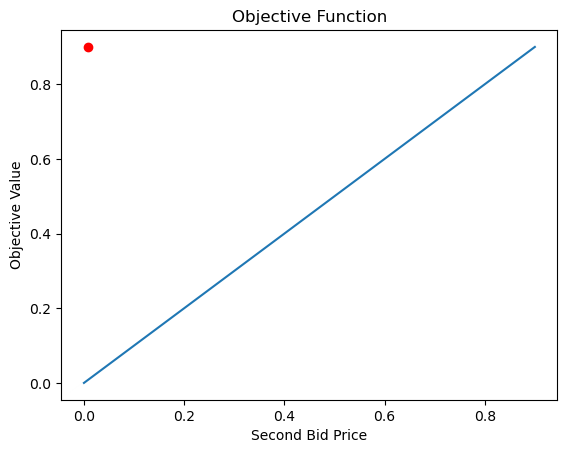

In [86]:
# goal is to quickly identify user probabilities
    # If less than 10 rounds, then use a third to find determine early probabilities
# expected value should be EV >=  Click_Rate_X * (1 - 2nd bid price) + (1-Click_Rate_X) - 2nd bid price
# need to compare the expected values for each user at any given time. 



click_rate_x = 0.5

def objective(second_bid,click_rate):
  return (click_rate * (1 - second_bid) + (1-click_rate) * (0-second_bid)).max()

click_rates = np.arange(0,1,0.1)
second_bid = np.arange(0, 1, 0.001)


obj_values = []

for x in click_rates:
  obj_values.append(objective(second_bid,x))

plt.figure()
sns.lineplot( x=second_bid, y=obj_values)
plt.xlabel('Second Bid Price')  
plt.ylabel('Objective Value')
plt.title('Objective Function')

max_index = np.argmax(obj_values)
plt.plot(second_bid[max_index], obj_values[max_index], 'ro')

plt.show()

In [72]:
click_rates

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [88]:
obj_values

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9]

In [89]:
objective(second_bid,0.9)

0.9

In [85]:
(click_rate * (1 - second_bid) + (1-click_rate) * (0-second_bid)).max()

0.5